In [ ]:
# Download Kaggle data
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alincijov/self-driving-cars

!unzip /content/self-driving-cars.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/1479502279730506173.jpg  
  inflating: images/1479502280230536426.jpg  
  inflating: images/1479502280730839737.jpg  
  inflating: images/1479502281729824146.jpg  
  inflating: images/1479502282229848985.jpg  
  inflating: images/1479502282730102580.jpg  
  inflating: images/1479502283731724690.jpg  
  inflating: images/1479502284232432719.jpg  
  inflating: images/1479502285221790200.jpg  
  inflating: images/1479502285730163274.jpg  
  inflating: images/1479502286231098378.jpg  
  inflating: images/1479502287230097438.jpg  
  inflating: images/1479502287730246905.jpg  
  inflating: images/1479502288231261057.jpg  
  inflating: images/1479502288731301852.jpg  
  inflating: images/1479502289730529475.jpg  
  inflating: images/1479502290232668314.jpg  
  inflating: images/1479502291230742118.jpg  
  inflating: images/1479502292231318149.jpg  
  inflating: images/1479502293232480074.jpg  
  inflating: images/147950229

In [ ]:
import os
import glob
import time

import numpy as np
import pandas as pd

from PIL import Image, ImageDraw
import matplotlib.pylab as plt
import cv2

# fix random seed
np.random.seed(2023)

import torch
import torchvision
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, draw_bounding_boxes
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from sklearn.model_selection import train_test_split

In [ ]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Load data

images_dir = '/content/images/'
labels_train_path    = '/content/labels_train.csv'
labels_val_path      = '/content/labels_val.csv'
labels_trainval_path = '/content/labels_trainval.csv'

labels_train_df    = pd.read_csv(labels_train_path)
labels_val_df      = pd.read_csv(labels_val_path)
labels_trainval_df = pd.read_csv(labels_trainval_path)

labels_val_df.head(5)

,frame,xmin,xmax,ymin,ymax,class_id
0,1478899046136829030.jpg,201,206,129,135,5
1,1478899046136829030.jpg,203,210,150,158,1
2,1478899046136829030.jpg,215,219,130,135,5
3,1478899046136829030.jpg,222,234,145,162,1
4,1478899046136829030.jpg,223,235,149,160,1


In [ ]:
print("class_id in csv:", labels_val_df['class_id'].unique())

# dictionary to convert class_id to class_name (inter -> string)
classes_dict = {1:'car', 2:'truck', 3:'pedestrian', 4:'bicyclist', 5:'light'}

# drop filename bị trùng
train_df = labels_train_df[~labels_train_df.duplicated(subset=['frame'])]
val_df = labels_val_df[~labels_val_df.duplicated(subset=['frame'])]
train_df.shape[0], val_df.shape[0]

class_id in csv: [5 1 2 3 4]


(18000, 4241)

# Faster-RCNN_Pytorch
- https://www.kaggle.com/code/hrithik22122/01-faster-rcnn-pytorch
- https://www.youtube.com/watch?v=qC4yEiJOJtM

1. input: list of tensors, each of shape [C, H, W], in 0-1 range
2. Training:
- input tensors
- a targets (list of dictionary), containing:
- -  boxes (FloatTensor[N, 4]): [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
- - labels (Int64Tensor[N]): the class label for each ground-truth box
- **returns** a Dict[Tensor]: classification and regression losses for RPN & R-CNN
3. Inference: the model
- requires only the input tensors
- **returns** the post-processed predictions as a List[Dict[Tensor]], one for each input image:
- - boxes (FloatTensor[N, 4]): predicted boxes in [x1, y1, x2, y2] format
- - labels (Int64Tensor[N])
- - scores (Tensor[N])

In [ ]:
# avaible obj detectors in pytorch
dir(torchvision.models.detection)

['FCOS',
 'FCOS_ResNet50_FPN_Weights',
 'FasterRCNN',
 'FasterRCNN_MobileNet_V3_Large_320_FPN_Weights',
 'FasterRCNN_MobileNet_V3_Large_FPN_Weights',
 'FasterRCNN_ResNet50_FPN_V2_Weights',
 'FasterRCNN_ResNet50_FPN_Weights',
 'KeypointRCNN',
 'KeypointRCNN_ResNet50_FPN_Weights',
 'MaskRCNN',
 'MaskRCNN_ResNet50_FPN_V2_Weights',
 'MaskRCNN_ResNet50_FPN_Weights',
 'RetinaNet',
 'RetinaNet_ResNet50_FPN_V2_Weights',
 'RetinaNet_ResNet50_FPN_Weights',
 'SSD300_VGG16_Weights',
 'SSDLite320_MobileNet_V3_Large_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'anchor_utils',
 'backbone_utils',
 'faster_rcnn',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos',
 'fcos_resnet50_fpn',
 'generalized_rcnn',
 'image_list',
 'keypoint_rcnn',
 'keypointrcnn_resnet50_fpn',
 'mask_rcnn',
 'maskrcnn_resnet50_fpn'

## data

In [ ]:
n_classes = 5 + 1 #  plus BG

In [ ]:
df = labels_train_df[:150]

# bbox format of RCNN: [x_min, y_min, x_max, y_max]
# reoder columns
df[['frame','xmin', 'ymin', 'xmax', 'ymax','class_id']]

def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)
  return img.to(device).float()

class SeflDrivingCarDataset(Dataset):
  w , h = 224 , 224

  def __init__(self , df  , image_root_dir = '/content/images' ):
    self.image_dir = image_root_dir
    self.df = df
    self.files = glob.glob(self.image_dir + '/*.jpg')
    self.image_infos = df.frame.unique()

  def __len__(self):
    return len(self.image_infos)

  def __getitem__(self ,ix ):
    # img
    img_id   = self.image_infos[ix]
    img_path = f'/content/images/{img_id}'
    img = Image.open(img_path).convert('RGB')
    img = np.array(img.resize((self.w ,self.h) , resample = Image.BILINEAR))/255.0
    img = preprocess_image(img)

    # data (class + bbox)
    data   = df[df['frame'] == img_id] # take unique filename
    # class
    labels = data['class_id'].values.tolist()
    # bbox
    boxes = data[['xmin', 'ymin' ,'xmax' ,'ymax']].values.astype(np.uint32).tolist()
    # store class + bbox as target dict
    target = {}
    target["boxes"]  = torch.Tensor(boxes).float()
    target["labels"] = torch.Tensor([i for i in labels]).long()
    return img , target

  def collate_fn(self ,batch):
    return tuple(zip(*batch))

# Train Test Split
trn_ids , val_ids = train_test_split(df.frame.unique(), test_size =0.1, random_state =99)
trn_df  , val_df  = df[df['frame'].isin(trn_ids)] , df[df['frame'].isin(val_ids)]

# CLass obj
train_ds = SeflDrivingCarDataset(trn_df)
val_ds   = SeflDrivingCarDataset(val_df)

# DataLoader( class obj)
train_loader = DataLoader(train_ds,  batch_size = 4, collate_fn = train_ds.collate_fn, drop_last =True)
val_loader   = DataLoader(val_ds,    batch_size = 4, collate_fn = val_ds.collate_fn,   drop_last =True )

## build model

In [ ]:
def get_model():
  # download
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained =True)
  # take the number of input feature of Predictor
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace by OUR OWN PREDICTOR
  model.roi_heads.box_predictor = FastRCNNPredictor( in_features , n_classes )
  return model

In [ ]:
def train_batch( inputs, model , optimizer):
  # train model
  model.train()

  # take data
  input , targets = inputs

  # Push data to GPU
  input   = list(image.to(device) for image in input)
  targets = [{k:v.to(device) for k,v in target.items()} for target in targets]

  # empty gradient
  optimizer.zero_grad()
  losses = model(input , targets)
  loss   = sum(loss for loss in losses.values())

  # gradient
  loss.backward()
  # update
  optimizer.step()

  return loss , losses

@torch.no_grad()
def validate_batch(inputs, models):
  model.train()
  input , targets = inputs
  input   = list(image.to(device) for image in input)
  targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
  optimizer.zero_grad()
  losses = model(input , targets)
  loss = sum(loss for loss in losses.values())
  return loss ,losses

In [ ]:
loss_criterions = ['loss_classifier',    'loss_box_reg',
                   'loss_objectness',    'loss_rpn_box_reg']

model = get_model().to(device)

optimizer = torch.optim.SGD(model.parameters() , lr=0.005 ,
                            momentum = 0.9 , weight_decay= 0.0005 )

### returns a Dict[Tensor]: classification and regression losses for RPN & R-CNN

# 'loss_classifier': cl, 'loss_box_reg': rl, 'loss_objectness': ol, 'loss_rpn_box_reg': rpnl
# 'total_loss': tl

EPOCHS = 20

print('                    ****************** Start Training *****************                             ')
start = time.time()

tcl , trl , tol , trpnl ,ttl = [] ,[] ,[] ,[] ,[]  # train
vcl , vrl , vol , vrpnl ,vtl = [] ,[] ,[] ,[] ,[]  # val

for epoch in range(EPOCHS):
  print(f'EPOCH {epoch+1}')
  tecl , terl , teol , terpnl ,tetl = [] ,[] ,[] ,[] ,[]
  vecl , verl , veol , verpnl ,vetl = [] ,[] ,[] ,[] ,[]

  # TRAIN
  for ix , batch in enumerate(train_loader):
    # train
    loss , losses = train_batch(batch , model , optimizer )

    # take all loss
    los_loss , reg_loss , loss_obj , loss_rpn_box_reg = [losses[k] for k in  loss_criterions]
    tot_loss = los_loss + reg_loss + loss_obj + loss_rpn_box_reg

    # store loss values
    tecl.append(los_loss.detach().cpu().numpy()) , terl.append(reg_loss.detach().cpu().numpy()) , teol.append(loss_obj.detach().cpu().numpy())
    terpnl.append(loss_rpn_box_reg.detach().cpu().numpy()) ,tetl.append(tot_loss.detach().cpu().numpy())

    if ix%600 == 0 and ix!=0:
        print(f'{ix} batches completed')

  print(f'Training - Total Loss {np.mean(tetl):.3f} | Classification Loss {np.mean(tecl):.3f} | Regression Loss {np.mean(terl):.3f} ',end=" ")
  print(f'| Object Loss {np.mean(teol):.3f} | RPN Loss {np.mean(terpnl):.3f}' )

  tcl.append(np.mean(tecl)) , trl.append(np.mean(terl)) , tol.append(np.mean(teol)) , trpnl.append(np.mean(terpnl)) ,ttl.append(np.mean(tetl))


  # VAL
  for ix , batch in enumerate(val_loader):
    loss , losses = validate_batch(batch ,model )

    los_loss , reg_loss , loss_obj , loss_rpn_box_reg = [losses[k] for k in  loss_criterions]
    tot_loss = los_loss + reg_loss + loss_obj + loss_rpn_box_reg

    vecl.append(los_loss.detach().cpu().numpy()) , verl.append(reg_loss.detach().cpu().numpy()) , veol.append(loss_obj.detach().cpu().numpy())
    verpnl.append(loss_rpn_box_reg.detach().cpu().numpy()) ,vetl.append(tot_loss.detach().cpu().numpy())

  print(f'Validation - Total Loss {np.mean(vetl):.5f} | Classification Loss {np.mean(vecl):.5f} | Regression Loss {np.mean(verl):.5f} ',end=" ")
  print(f'| Object Loss {np.mean(veol):.5f} | RPN Loss {np.mean(verpnl):.5f}' )

  vcl.append(np.mean(vecl)) , vrl.append(np.mean(verl)) , vol.append(np.mean(veol)) , vrpnl.append(np.mean(verpnl)) ,vtl.append(np.mean(vetl))

  print('===============================================================================Done')
  print()


print('                    ****************** Training Completed *****************                             ')
end = time.time()
total_time = end-start

                    ****************** Start Training *****************                             
EPOCH 1
Training - Total Loss 9.086 | Classification Loss 0.416 | Regression Loss 0.018  | Object Loss 2.042 | RPN Loss 6.610
Validation - Total Loss 5.86789 | Classification Loss 0.27538 | Regression Loss 0.06639  | Object Loss 1.27069 | RPN Loss 4.25543
===============================================================================Done

EPOCH 2
Training - Total Loss 7.739 | Classification Loss 0.188 | Regression Loss 0.033  | Object Loss 1.241 | RPN Loss 6.277
Validation - Total Loss 5.19645 | Classification Loss 0.26869 | Regression Loss 0.06043  | Object Loss 0.66390 | RPN Loss 4.20344
===============================================================================Done

EPOCH 3
Training - Total Loss 6.968 | Classification Loss 0.113 | Regression Loss 0.029  | Object Loss 0.768 | RPN Loss 6.057
Validation - Total Loss 5.45912 | Classification Loss 0.09580 | Regression Loss 0.02445  | 

In [ ]:
def plot_pf(tl , vl , head_name):
    plt.plot(range(len(tl)), tl,  'b', label='Training loss')
    plt.plot(range(len(vl)), vl , 'r', label='Test loss')
    plt.title(head_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('off')
    plt.show()

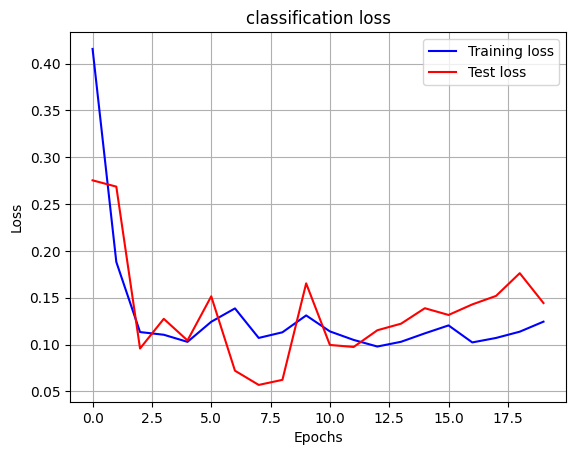

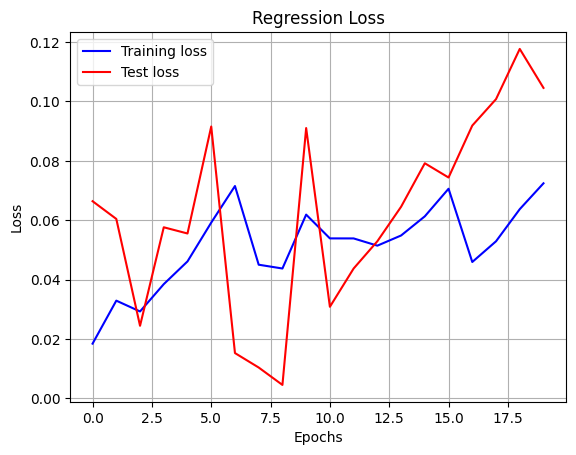

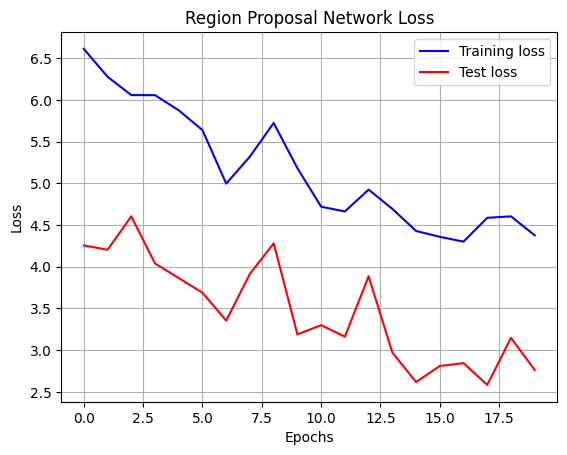

In [ ]:
plot_pf(tcl , vcl    ,'classification loss')
plot_pf(trl , vrl    , "Regression Loss")
plot_pf(trpnl, vrpnl , "Region Proposal Network Loss")

In [ ]:
from torchvision.ops import nms
from torchvision.utils import draw_bounding_boxes

def decode_output(output):
    # take bbox, label, conf
    bbs    = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([classes_dict[i] for i in output['labels'].cpu().detach().numpy()])
    confs  = output['scores'].cpu().detach().numpy()
    # do nms
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for ix, (images, targets) in enumerate(val_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
       bb, conf, label = decode_output(output)
       draw_bounding_boxes(images[ix].type(torch.uint8),
                           torch.tensor(bb), label)